## The MNIST Dataset

The MNIST dataset (Modified National Institute of Standards and Technology) is one of the most popular datasets used in machine learning and computer vision. It consists of a large collection of grey scale images of handwritten digits (0–9), which is widely used for training and testing in image processing and classification tasks.

The dataset contains 60,000 training images and 10,000 testing images. Each image is a 28x28 pixel square (784 pixels in total) with pixel values ranging from 0 to 255. The dataset is divided into 10 classes, one for each digit.

It is so common that most machine learning libraries provide a built-in function to download and load the dataset. For example the torchvision library in PyTorch provides a built-in function to download and load the MNIST dataset.

However in this notebook we are going to download and process the images from source as this will provide a deeper understating of data sets in general and how they are processed in machine learning.

## Setup

To start with we are going to import the libraries we need including our Utils library which contains some helper functions to download datasets. We will also see if we are in the lab and if so we will download the data to the local file system (/transfer). If we are not in the lab we will download the data to the current working directory.




In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import struct
import sys


sys.path.append("../")
import Utils

print(f"{Utils.in_lab()=}")

Utils.in_lab()=False


We will define a download location for the data, then use the download function to download it all. The data is split into training and testing data so we will download both. In this case as the data is self contained in a single file we will download it all into a single folder. If we we were downloading a dataset that was split into multiple files we would download each file into a separate folder.

In [5]:
DATASET_LOCATION = ""
if Utils.in_lab():
    DATASET_LOCATION = "/transfer/MNIST/"
else:
    DATASET_LOCATION = "./MNIST/"
# now we will create the folder if it does not exist
pathlib.Path(DATASET_LOCATION).mkdir(parents=True, exist_ok=True)

We can use the [pathlib](https://docs.python.org/3/library/pathlib.html) module to do most of the work we need for file processing. In the case above we will create a new folder in the location we defined. If the folder already exists we will ignore it. 

Next we are going to download the data, however we only really want to download it if it is not already present. We can use the pathlib module to check if the file exists and only download it if it does not. The files we are looking for are :

    - train-images-idx3-ubyte.gz:  training set images 
    - train-labels-idx1-ubyte.gz:  training set labels 
    - t10k-images-idx3-ubyte.gz:   test set images 
    - t10k-labels-idx1-ubyte.gz:   test set labels 

We will download them from the google mirror outlined here https://github.com/cvdfoundation/mnist

In [12]:
files = [
    "train-images-idx3-ubyte.gz",
    "train-labels-idx1-ubyte.gz",
    "t10k-images-idx3-ubyte.gz",
    "t10k-labels-idx1-ubyte.gz",
]
URL = "https://storage.googleapis.com/cvdf-datasets/mnist/"


for file in files:
    if not pathlib.Path(DATASET_LOCATION + file).exists():
        print(f"Downloading {file}")
        Utils.download(f"{URL}{file}", DATASET_LOCATION + file)

/Users/jmacey/.pyenv/versions/anaconda3-2024.02-1/lib/python3.11/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
./MNIST/train-images-idx3-ubyte.gz: 100%|██████████| 9.45M/9.45M [00:03<00:00, 2.69MiB/s]
/Users/jmacey/.pyenv/versions/anaconda3-2024.02-1/lib/python3.11/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


./MNIST/train-labels-idx1-ubyte.gz: 100%|██████████| 28.2k/28.2k [00:00<00:00, 877kiB/s]
/Users/jmacey/.pyenv/versions/anaconda3-2024.02-1/lib/python3.11/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


./MNIST/t10k-images-idx3-ubyte.gz: 100%|██████████| 1.57M/1.57M [00:00<00:00, 1.75MiB/s]
/Users/jmacey/.pyenv/versions/anaconda3-2024.02-1/lib/python3.11/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


./MNIST/t10k-labels-idx1-ubyte.gz: 100%|██████████| 4.44k/4.44k [00:00<00:00, 3.30MiB/s]


The downloaded files are compressed using gzip we need to uncompress them before we can use them. We can use the gzip module to do this.

In [13]:
import gzip

for file in files:
    if not pathlib.Path(DATASET_LOCATION + file[:-3]).exists():
        print(f"Unzipping {file}")
        with gzip.open(DATASET_LOCATION + file, "rb") as f_in:
            with open(DATASET_LOCATION + file[:-3], "wb") as f_out:
                f_out.write(f_in.read())

Unzipping train-images-idx3-ubyte.gz
Unzipping train-labels-idx1-ubyte.gz
Unzipping t10k-images-idx3-ubyte.gz
Unzipping t10k-labels-idx1-ubyte.gz


## Data Format

Now we have downloaded the data we need to understand the format of the data. The data is stored in a binary format which is not human readable. The data is stored in a format called IDX which is a simple format for vectors and multidimensional matrices of various numerical types. The IDX file format is a simple format for vectors and multidimensional matrices of various numerical types. The basic format is

    magic number
    size in dimension 0
    size in dimension 1
    size in dimension 2
    .....
    size in dimension N
    data

In particular the MNIST is formatted as follows :

```
Labels 
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000801(2049) magic number (MSB first)
0004     32 bit integer  60000            number of items
0008     unsigned byte   ??               label
0009     unsigned byte   ??               label
........
xxxx     unsigned byte   ??               label

The labels values are 0 to 9. 
```

And for the images 

```
 IMAGE FILE FORMAT
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000803(2051) magic number
0004     32 bit integer  60000            number of images
0008     32 bit integer  28               number of rows
0012     32 bit integer  28               number of columns
0016     unsigned byte   ??               pixel
0017     unsigned byte   ??               pixel
........
xxxx     unsigned byte   ??               pixel

Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black). 
```

We can write python functions to extract the data and convert it into numpy arrays, one for the image data and one for the labels. We can then use the matplotlib library to display the images.

## Loading Labels

We are going to use the python ```struct``` module to read the header data then skip the header and read the rest of the data. We can then convert the data into a numpy array.

Note there is minimal error checking in this code, it is assumed the data is in the correct format, however we should be able to check the size of the data and the number of labels to ensure they match.


In [14]:
def load_mnist_labels(filename: str) -> np.ndarray:
    with open(filename, "rb") as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
        if len(labels) != num:
            raise ValueError(f"Expected {num} labels, but got {len(labels)}")
    return labels

In [19]:
# We can now load the labels from both the datasets.

train_labels = load_mnist_labels(DATASET_LOCATION + "train-labels-idx1-ubyte")
test_labels = load_mnist_labels(DATASET_LOCATION + "t10k-labels-idx1-ubyte")

print(len(train_labels), len(test_labels))
print(train_labels[0], test_labels[0])

60000 10000
5 7


For the images we can do the same thing, not the header is a little different.

In [20]:
def load_mnist_images(filename: str) -> np.ndarray:
    with open(filename, "rb") as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num, rows, cols)
        if len(images) != num:
            raise ValueError(f"Expected {num} images, but got {len(images)}")
    return images


# We can now load the images from both the datasets.
train_images = load_mnist_images(DATASET_LOCATION + "train-images-idx3-ubyte")
test_images = load_mnist_images(DATASET_LOCATION + "t10k-images-idx3-ubyte")

Finally we can display the images using the matplotlib library.

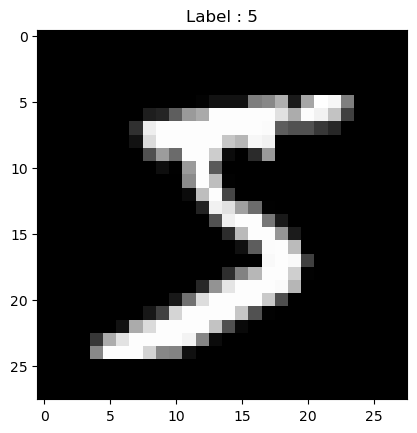

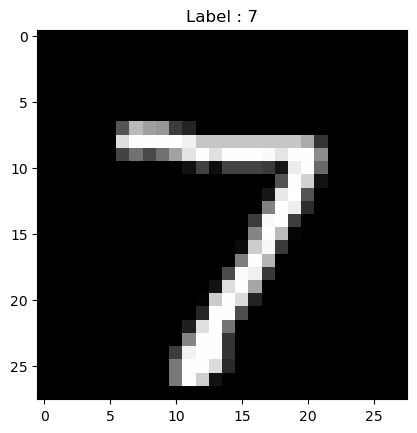

In [24]:
def display_image(image: np.array, label: str) -> None:
    plt.title(f"Label : {label}")
    plt.imshow(image, cmap="gray")
    plt.show()


# We can now display the first image from the training dataset.

display_image(train_images[0], train_labels[0])
display_image(test_images[0], test_labels[0])

# Conclusions

We will use this data again in another example when we actually train a model with it. As mentioned in the introduction the MNIST dataset can also be downloaded using the torchvision library in PyTorch.

```python
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
```

This will also convert the data to a tensor which is the format we need to use it in PyTorch.